<a href="https://colab.research.google.com/github/fernandabomtorin16/one-shot-class/blob/main/T2_Camada_customizada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho #2 - Função de custo e camada customizada

Nesse trabalho você vai criar e treinar uma RNA com camada e função de custo customizadas.

O problema que será resolvido consiste na classificação "one-shot" de vestuários do conjunto Fashion-MINIST.

Esse trabaalho é baseado em "Hadsell-et-al., Dimensionality Reduction by Learning an Invariant Mapping", (http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf).

## Coloque o seu nome aqui:

Nome: Fernanda Bomtorin

### Importação das bilbiotecas necessárias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.19.0


## 2. Classificação "one-shot"

Para apresentar um exemplo realista de uso de uma função de custo e uma camada customizada, você vai desenvolver um modelo para resolver uma tarefa de classificação "one-shot" usando uma RNA siamesa e a função de custo contrastante, que será vista mais adiante nesse notebook.

Esse tipo de modelo é usado para identificação de pessoas pela face e para classificação multiclasse quando se tem poucos exemplos de cada classe. Nota-se que classificação multiclasse usando o método "one-shot" foi visto na disciplina de Redes Convolucionais.

Na aula de reconhecimento de pessoas pela face foi visto com detalhes o uso da função de custo tripla, que é treinada com uma rede siamesa. Naquela aula também foi visto o método de usar somente duas imagens para identificar faces, mas não com detalhes.

Na Figura 1 é apresentado um esquema da rede siamesa utilizada nesse tipo de tarefa. Esse tipo de modelo é utilizado para verificar se duas imagens (ou dois vetores) pertencem ou não à mesma classe.




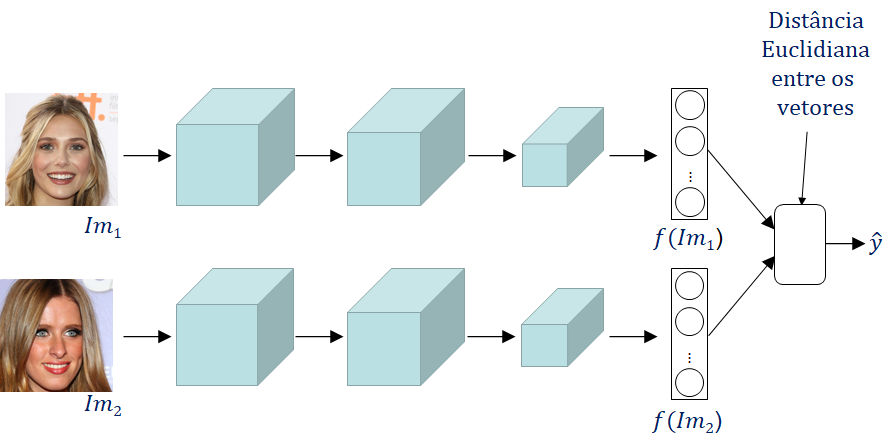

('Classificação_one_shot.png')
<center>Figura 1 - Esquema de modelo para classificação one-shot com função de custo contrastante.</center>


A ideia desse modelo é usar uma rede neural para gerar os vetores de características das duas imagens de forma que:

1. Se as duas imagens forem similares, então os vetores de caracteríticas devem ser similares; e
2. Se as duas imagens forem diferentes, então os vetores de características devem ser diferentes.

Nesse modelo as duas imagens são processadas em paralelo pela mesma rede, gerando dois vetores de características. A distância Euclidiana entre os dois vetores é calculada e as duas imagens são classificadas em função da distância entre elas da seguinte forma:

- Se a distância for maior do que um limiar pré-selecionado, então, as imagens são consideradas de classes diferentes;
- Se a distância for menor do que o limiar, então as imagens são consideradas da mesma classe.

Esse método de classificação "one-shot" foi criado por: R. Hadrell, S. Chopra e Y. Lecun, "Dimensionality reduction by learning an invariant mapping", 2006.

Para treinar um modelo desse tipo é utilizada a função de custo contrastante, cujo nome vem de contraste.

## 3. Carregar e pré-processar dados


### 3.1 Carregar dados

Os dados utilizado nesse exemplo é conjunto de vestuário da Fashion-MINIST, que pode ser carregado diretamento de Keras.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print('Dimensão dos dados de entrada de treinamento =', x_train.shape)
print('Dimensão dos dados de entrada de teste =', x_test.shape)
print('Dimensão dos dados de saída de treinamento =', y_train.shape)
print('Dimensão dos dados de saída de teste =', y_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Dimensão dos dados de entrada de treinamento = (60000, 28, 28)
Dimensão dos dados de entrada de teste = (10000, 28, 28)
Dimensão dos dados de saída de treinamento = (60000,)
Dimensão dos dados de saída de teste = (10000,)


### 3.2 Processar dados

Como as imagens do conjunto de dígitos MNIST são pequenas e em tons de cinza, para simplificar vamos transformar as imagens em vetores e usar uma rede com camadas densas.

Dessa forma é necessário redimensionar as imagens para torná-las vetores. Além disso, os pixels das imagens devem ser normalizados para srem valores reais entre 0 e 1.

In [ ]:
# Número total de pixels nas imagens
nx = x_train.shape[1]*x_train.shape[2]

# Redimensionamento e normalização das das imagens
x_train_flat = np.reshape(x_train, (x_train.shape[0], nx))/255.
x_test_flat = np.reshape(x_test, (x_test.shape[0], nx))/255.

print('Dimensão dos dados de entrada de treinamento =', x_train_flat.shape)
print('Dimensão dos dados de entrada de teste =', x_test_flat.shape)

Dimensão dos dados de entrada de treinamento = (60000, 784)
Dimensão dos dados de entrada de teste = (10000, 784)


#### Gráficos de alguns exemplos

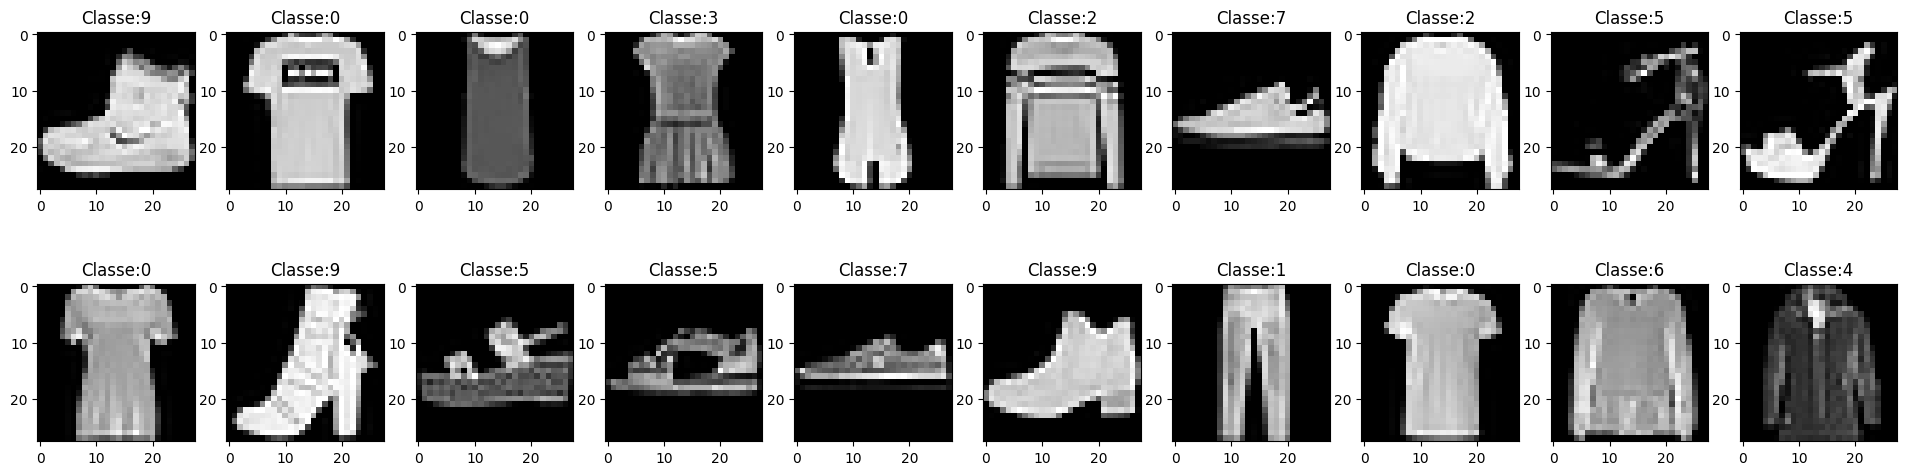

In [ ]:
fig, axs = plt.subplots(2,10,figsize=(24,6))
index = 0
for i in range(2):
    for j in range(10):
        axs[i,j].imshow(x_train[index], cmap='gray', vmin=0, vmax=255)
        axs[i,j].set_title('Classe:' + str(y_train[index]))
        index += 1
plt.show()

## 4. Formação dos pares de imagens

Para treinar uma rede siamensa com duas entradas temos que formar pares de imagens de entrada.


Execute a célula abaixo para criar a função `create_pairs()` que realiza a operação de criar pares de imagens de mesmo dígitos e de diferentes dígitos.

Essa função recebe como entrada um tensor com as imagens e uma lista com os índices das imagens de cada dígito.

- Observa-se que essa função, para cada imagem deve criar dois exemplos de treinamento, o primeiro exemplo é de um par de imagens de mesmo dígito e o segundo para imagens com dígitos diferentes.

- Observe que não tem muito problema uma mesma imagem ser usada mais do que uma vez um par.

In [ ]:
# Função que cria pares de imagens com saídas 0 e 1
def create_pairs(img, digit_indices):
    '''
    Entradas:
        img = tensor de imagens
        digit_indices = lista de classes das imagens

    Retorna:
        tensor com pares de imagens
        tensor com classes dos pares
    '''
    # Inicializa lista de pares de imagens e saídas reais
    pairs = []
    labels = []

    # Determina numero de exemplos do dígito que possui menor número de exemplos
    n = min([len(digit_indices[d]) for d in range(10)]) - 1

    # Percorre todos os dígitos
    for d in range(10):

        # Forma n pares para cada tipo de dígito e para cada imagem de dígito forma 2 pares
        for i in range(n):
            # Seleciona indices de imagens de mesmo dígito
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]

            # Forma par com imagens de mesmo dígito
            pairs += [[img[z1], img[z2]]]

            # Gera número aleatório para selecionar o dígito da imagem diferente
            inc = np.random.randint(1, 10)
            dn = (d + inc) % 10

            # Seleciona índices de imagens de diferentes dígitos
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]

            # Forma par com imagens de diferentes dígitos
            pairs += [[img[z1], img[z2]]]

            # Define saídas dos dois pares
            labels += [1, 0]

    return np.array(pairs), np.array(labels)

### Exercício #1:  Criar lista de índices das images de cada tipo de dígito

Para criar os pares de exemplos de treinamento e de teste é necessário primeiramente criar as listas com os índices das imagens de cada tipo de dígito para depois chamar a função `create_pairs()` passando as imagens e essas listas.

Observa-se não são usadas as imagens de teste para acompanhar o treinamemto da rede, elas serão usadas somente para testar o modelo após o treinamento.

Observa-se que devem ser criadas 10 listas, uma para cada tipo de dígito.

Uma forma fácil de criar essas listas é usando a função `np.where` para selecionar cada um dos 10 diferentes dígitos.

In [ ]:
import numpy as np

# Cria listas de índices das imagens de treinamento para cada tipo de dígito
digit_indices_train = [np.where(y_train == d)[0] for d in range(10)]

# Cria listas de índices das imagens de teste para cada tipo de dígito
digit_indices_test = [np.where(y_test == d)[0] for d in range(10)]

print('Número de elementos da lista:', len(digit_indices_train))
print('Indices da imagens com dígito 0:', digit_indices_train[0])
print('Indices da imagens com dígito 1:', digit_indices_train[1])
print('Indices da imagens com dígito 2:', digit_indices_train[2])
print('Indices da imagens com dígito 3:', digit_indices_train[3])
print('Indices da imagens com dígito 4:', digit_indices_train[4])
print('Indices da imagens com dígito 5:', digit_indices_train[5])
print('Indices da imagens com dígito 6:', digit_indices_train[6])
print('Indices da imagens com dígito 7:', digit_indices_train[7])
print('Indices da imagens com dígito 8:', digit_indices_train[8])
print('Indices da imagens com dígito 9:', digit_indices_train[9])

Número de elementos da lista: 10
Indices da imagens com dígito 0: [    1     2     4 ... 59974 59985 59998]
Indices da imagens com dígito 1: [   16    21    38 ... 59989 59991 59996]
Indices da imagens com dígito 2: [    5     7    27 ... 59977 59981 59993]
Indices da imagens com dígito 3: [    3    20    25 ... 59971 59980 59997]
Indices da imagens com dígito 4: [   19    22    24 ... 59984 59986 59990]
Indices da imagens com dígito 5: [    8     9    12 ... 59983 59995 59999]
Indices da imagens com dígito 6: [   18    32    33 ... 59973 59987 59988]
Indices da imagens com dígito 7: [    6    14    41 ... 59951 59979 59992]
Indices da imagens com dígito 8: [   23    35    57 ... 59962 59967 59994]
Indices da imagens com dígito 9: [    0    11    15 ... 59932 59970 59978]


**Saída esperada**

    Número de elementos da lista: 10
    Indices da imagens com dígito 0: [    1     2     4 ... 59974 59985 59998]
    Indices da imagens com dígito 1: [   16    21    38 ... 59989 59991 59996]
    Indices da imagens com dígito 2: [    5     7    27 ... 59977 59981 59993]
    Indices da imagens com dígito 3: [    3    20    25 ... 59971 59980 59997]
    Indices da imagens com dígito 4: [   19    22    24 ... 59984 59986 59990]
    Indices da imagens com dígito 5: [    8     9    12 ... 59983 59995 59999]
    Indices da imagens com dígito 6: [   18    32    33 ... 59973 59987 59988]
    Indices da imagens com dígito 7: [    6    14    41 ... 59951 59979 59992]
    Indices da imagens com dígito 8: [   23    35    57 ... 59962 59967 59994]
    Indices da imagens com dígito 9: [    0    11    15 ... 59932 59970 59978]

### Exercício #2: Criar pares de exemplos de treinamento e de teste

Utilizando a função `create_pairs()`  e as listas de índices de dígitos crie na célula abaixo os pares de treinamento e de teste.

In [ ]:
""" PARA VOCÊ FAZER: Criar pares de imagens de treinamento e de teste """

# Cria exemplos de pares de treinamento
par_train, y_par_train = create_pairs(x_train_flat, digit_indices_train)

# Cria exemplos de pares de treinamento
par_test, y_par_test = create_pairs(x_test_flat, digit_indices_test)

# Mostra alguns pares de imagens de treinamento
print('Dimensão do tensor de pares de treinamento:', par_train.shape)
print('Dimensão do tensor de pares de teste:', par_test.shape)
print('Dimensão do tensor de saída de treinamento:', y_par_train.shape)
print('Dimensão do tensor de saída de teste:', y_par_test.shape)

Dimensão do tensor de pares de treinamento: (119980, 2, 784)
Dimensão do tensor de pares de teste: (19980, 2, 784)
Dimensão do tensor de saída de treinamento: (119980,)
Dimensão do tensor de saída de teste: (19980,)


**Saída esperada:**

    Dimensão do tensor de pares de treinamento: (119980, 2, 784)
    Dimensão do tensor de pares de teste: (19980, 2, 784)
    Dimensão do tensor de saída de treinamento: (119980,)
    Dimensão do tensor de saída de teste: (19980,)

Na célula abaixo é criada uma função para fazer gráficos das imagens de um par e depois um par de exemplo é apresentado.

Classe do par: 0


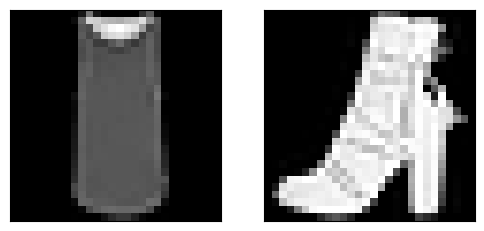

In [ ]:
# Função para fazer gráfico do par
def plot_par(par, index):
    plt.figure(figsize=(6, 6))
    for i in range(2):
        plt.subplot(1, 2, 1 + i)
        plt.imshow(np.reshape(par_train[index,i], (28, 28)), cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

# Seleciona índice do par de imagens para fazer o gráfico
index = 3
print('Classe do par:', y_par_train[index])
plot_par(par_train, index)

## 5. Função de custo contrastante

A função de custo contrastante faz com que a distância entre duas imagens de classes diferentes aumente e que a distânica entre duas imagens de mesma classe diminua.

Essa função de custo é baseada na seguinte equação de erro definida para cada exemplo de treinamento, que consiste de um par de imagens:

$$E_C^{(i)} = y^{(i)}_{real}(D^{(i)})^2 + (1-y^{(i)}_{real}) max(M - D^{(i)}, 0)^2$$

onde $E_C^{(i)}$ é o erro para o i-ésimo par de imagens, $y^{(i)}_{real}$ é a saída real do par de imagens, $M$ é uma constante denominada margem e $D^{(i)}$ é a distância Euclidiana entre os vetores de características das duas imgens do i-ésimo par.

Nesse tipo de problema, a entrada de cada exemplo consiste de um par de imagens e a saída real consiste na classe de cada exemplo, definida por:

$$y^{(i)}_{real} = \begin{cases} 0, & para & imagens & similares \\ 1, & para & imagens & diferentes \end{cases}$$

onde $y^{(i)}_{real}$ é a classe desejada do i-ésimo exemplo e $M$ é um número positivo que representa uma margem para forçar uma distância mínima entre vetores de características de imagens similares e diferentes.

Note que:

- Se $y^{(i)}_{real} = 0$, então, $E_C^{(i)} = max(M - D^{(i)}, 0)^2$, portanto, $E_C^{(i)} < (D^{(i)})^2$ (imagens similares)


- Se $y^{(i)}_{real} = 1$, então, $E_C^{(i)} = (D^{(i)})^2$ (imagens diferentes)

Os termos $y^{(i)}_{real}$ e $(1-y^{(i)}_{real})$ podem ser ser vistos como sendo pesos de ponderação que permitem que $(D^{(i)})^2$ ou  $max(M - D^{(i)}, 0)^2$ dominem o erro conforme a classe do par de imagens.


A função de custo contrastive é definida como sendo a média da função de erro para todos os exemplos treinamento, assim, tem-se:

$$J_C = \frac {1}{m} \sum\limits_{i=1}^{m} y^{(i)}_{real}(D^{(i)})^2 + (1-y^{(i)}_{real}) max(M - D^{(i)}, 0)^2$$

onde $J_C$ é a função de custo contrastante, que depende dos parâmetros do modelo, e $m$ é o número de exemplos.

Ressalta-se que uma função de custo do Keras recebe como entradas as saídas reais e as saídas previstas pela rede, então, para implementar essa função de custo a saída prevista pela rede siamesa deve ser a distância Euclidiana entre os vetores de características da duas imagens, ou seja:

$$y^{(i)}_{prev} = D^{(i)}$$

Dessa forma, a última camada da rede siamesa deve calcular a distância Euclidiana entre os vetores de características das duas imagens.

### Exercício #3: Função de custo contrastante na forma de classe

Implemente  na célula abaixo a função de custo contrastante na forma de classe.

Observa-se que essa função de custo espera receber como saída prevista da rede a distância Euclidiana entre os vetores de características das duas imagens.

In [ ]:
""" PARA VOCÊ FAZER: Função e custo contrastante """

# Importa classe de funções de custo do Keras
from tensorflow.keras.losses import Loss
from tensorflow.keras import backend as K

# Cria classe de função de custo customizada usando a classe "Loss" do Keras
class ContrastiveLoss(Loss):
    # define valor padrão da margem (usar 0.5)
    margin = 0.5

    # Função para inicializar objeto da classe
    def __init__(self, margin):
        # Comando padrão para inicializar classes do Keras
        super().__init__()
        # Define margem
        self.margin = margin

    # Função executada pelo objeto instanciado com a classe
    def call(self, y_true, y_pred):
        # 1o termo
        termo1 = y_true*K.square(y_pred)

        # 2o termo
        termo2 = (1 - y_true) * K.square(K.maximum(self.margin - y_pred, 0))

        # Custo total
        loss = K.mean(termo1 + termo2)

        return loss

Teste da função de custo contrastante.

In [ ]:
# Cria lote de vetores de características
c1 = np.ones((5,1))
c2 = 0.5*np.ones((5,1))

# Instancia ojeto da classe da função de custo
CL = ContrastiveLoss(1.0)

# Calculo custo
loss = CL(c1,c2)
print('Função de custo:', loss.numpy())

Função de custo: 0.25


**Saída esperada:**

Função de custo: 0.25

## 6. RNA de geração de características

Para gerar os vetores de características das imagens vamos utlizar uma RNA com três camadas densas com a seguinte configuração:

- Número de neurônios das camadas: 128 neurônios
- Função de ativação das camadas: ReLu
- Camadas de dropout entre a 1a e 2a camadas densas e entre a 2a e 3a camadas densas


### Exercício #4: Configuração da RNA de extração de características

Na célula abaixo crie a rede de acordo com a configuração desejada.

In [ ]:
""" PARA VOCÊ FAZER: Criar a RNA de extração de características """

from tensorflow.keras import models
from tensorflow.keras import layers

# Função para criar rna geradora de características
def rna_carac(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, input_shape=(input_dim,), activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation='relu'))

    return model

# Dimensão da entrada
input_dim = 784

# Cria RNA geradora dos vetores de características
rna_base = rna_carac(input_dim)

rna_base.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,504 (521.50 KB)

 Trainable params: 133,504 (521.50 KB)

 Non-trainable params: 0 (0.00 B)

**Saída desejada:**

    Model: "sequential"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    dense (Dense)                (None, 128)               100480    
    _________________________________________________________________
    dropout (Dropout)            (None, 128)               0         
    _________________________________________________________________
    dense_1 (Dense)              (None, 128)               16512     
    _________________________________________________________________
    dropout_1 (Dropout)          (None, 128)               0         
    _________________________________________________________________
    dense_2 (Dense)              (None, 128)               16512     
    =================================================================
    Total params: 133,504
    Trainable params: 133,504
    Non-trainable params: 0
    _________________________________________________________________



## 7. Rede siamesa

A primeira etapa para criar a rede siamesa é criar a camada de saída que calcula a distância entre os vetores e características, obtidos pela `rna_base`criada no exercício #5.


### Exercício #5: Camada customizada para calcular distância euclidina

A `rna_base` extrai os vetores de características de cada uma das imagens do par.

Na célula abaixo crie uma camada customizada na forma de classe para calcular a distância euclidiana entre os dois vetores de características.

A distância euclidiana entre dois vetores $v$ e $u$ é definida por:

$$ d = \sqrt {\sum_{i=1}^{n} (v_i - u_i)^2 }$$

onde $n$ é o número de elementos dos dois vetores, e $v_i$ e $u_i$ são respectivamente os i-ésimos elementos dos vetores $v$ e $u$.

In [ ]:
""" PARA VOCÊ FAZER: Camada customizada para calcular o quadrado da distância euclidiana"""

# Importa classe de camadas do Keras
from tensorflow.keras import layers

# Define classe de camada Distance
class EuclidianDistance(layers.Layer):
    # Inicializa objeto da classe
    def __init__(self):
        # Incialização
        super(EuclidianDistance, self).__init__()

    # Define cálculo realizado pela camada
    def call(self, inputs):
        # Separa os dois vetores
        v1, v2 = inputs

        # Calcula Adiciona a entrada ao valor do estado interno da camada
        dist = tf.math.reduce_sum(tf.square(v1-v2), axis=1)

        return dist

Execute a célula abaixo para testar a sua camada para calcular a distância euclidiana entre dois vetores.

Nesse teste temos um lote de 5 exemplo. Assim, a saída dessa camada deve consistir de 5 distâncias.

In [ ]:
# Define tensores vetores de entrada da camada
v1 = 0.9*tf.ones((5,8))
v2 = 0.8*tf.ones((5,8))

# Instância objeto da camada
dist = EuclidianDistance()

# Calcula saída da camada
d = dist([v1, v2])

# Mostra parâmetros da camada
print('Entrada 1:', v1.numpy())
print('Entrada 2:', v2.numpy())
print('Distância entre os vetores:', d.numpy())

Entrada 1: [[0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]]
Entrada 2: [[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]]
Distância entre os vetores: [0.07999995 0.07999995 0.07999995 0.07999995 0.07999995]


**Saída desejada:**

    Entrada 1: [[0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
     [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
     [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
     [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
     [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]]
    Entrada 2: [[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
     [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
     [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
     [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
     [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]]
    Distância entre os vetores: [0.2828426 0.2828426 0.2828426 0.2828426 0.2828426]


### Exercício #6: Configuração da rede siamesa

A `rna_base` extrai os vetores de características de cada uma das imagens. Dessa forma, a rede siamesa é composta por duas `rna_base`, uma para cada imagem dos pares.

A última camada da rede siamesa calcula a distância euclidiana entre os dois vetores de características, que é a saída desejada para a rede siamesa.

Na célula abaixo, crie a rede  siamesa usando a `rna_base` e a camada `EuclidianDistance`.

In [ ]:
""" PARA VOCÊ FAZER: Criar a RNA siamesa """

# Instancia camada para calculo da distância euclidiana
dist = EuclidianDistance()

# Define duas camdas de entrada, uma para cada imagem do par
img1 = layers.Input(shape=(784,))
img2 = layers.Input(shape=(784,))

# Extração dos vetores de características das duas imagens
feature_1 = rna_base(img1)
feature_2 = rna_base(img2)

# Cálculo da distãncia euclidiana entre os vetores de características
distance = dist([feature_1, feature_2])

# Instancia rede siamensa completa
siam = models.Model([img1, img2], distance)

# Summario da rede
siam.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │    133,504 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ euclidian_distance… │ (None)            │          0 │ sequential[0][0], │
│ (EuclidianDistance) │                   │            │ sequential[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 133,504 (521.50 KB)

 Trainable params: 133,504 (521.50 KB)

 Non-trainable params: 0 (0.00 B)

**Saída esperada:**

    Model: "model"
    __________________________________________________________________________________________________
    Layer (type)                    Output Shape         Param #     Connected to                     
    ==================================================================================================
    input_1 (InputLayer)            [(None, 784)]        0                                            
    __________________________________________________________________________________________________
    input_2 (InputLayer)            [(None, 784)]        0                                            
    __________________________________________________________________________________________________
    sequential (Sequential)         (None, 128)          133504      input_1[0][0]                    
                                                                     input_2[0][0]                    
    __________________________________________________________________________________________________
    distance (Distance)             (None,)              0           sequential[0][0]                 
                                                                     sequential[1][0]                 
    ==================================================================================================
    Total params: 133,504
    Trainable params: 133,504
    Non-trainable params: 0
    __________________________________________________________________________________________________

### Exercício #7: Teste da rede siamesa

Vamos avaliar a RNA não treinada para termos uma base do resultado esperado do treinamento. Para isso faça:

1. Execute o seu modelo com os 8 primeiros pares de imagens para calcular as distâncias entre elas.

2. Calcule a função de custo para as distâncias calculadas.



In [ ]:
""" PARA VOCÊ FAZER: Testar a RNA siamesa """

# Calcula previsões da RNA não treinada
distances = siam.predict([par_train[:8,0], par_train[:8,1]])
print('Distancias:', distances)

# Instancia função de custo
CL = ContrastiveLoss(1.0)

# Calcula função de custo
loss_value = CL(y_true=y_par_train[:8], y_pred=distances)
print("Custo antes do treinamento =", loss_value.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
Distancias: [4.3821135  4.621746   3.1227498  3.552323   1.1686565  2.7280545
 0.77155507 2.1441386 ]
Custo antes do treinamento = 3.8644426


**Saída esperada:**

    Distancias: [2.1851854 1.7764995 2.1596992 1.6642059 1.1728308 2.6285894 0.7883583
    1.3110877]
    Custo antes do treinamento = 1.4295471

## 8. Compilação, treinamento e teste da rede siamesa


### Exercício #8: Compilação da rede

A compilação da rede siamensa deve ser realzada da seguinte forma:
    
- Otimizador: Adam com taxa de aprendizado de 0.001
- Função de custo: Contrastante

Observa-se que se quisermos utilizar uma métrica temos que criar uma customizada, pois uma métrica comum compara a saída prevista pela rede (que é distância entre os vetores de características) com a classe do par. Isso nesse problema não faria sentido.  

Use um valor de 1.0 para a margem $M$ da função de custo contrastante.

In [ ]:
""" PARA VOCÊ FAZER: Compilar a RNA siamesa """

# Margem
MARGIN = 1.0

# Define objeto otimizador usando tf.keras.optimizer.Addam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compilação da RNA
siam.compile(loss=ContrastiveLoss(MARGIN), optimizer=optimizer)

### Exercício #9: Treinamento da RNA

Treine o seu modelo utilizando os seguintes parâmetros:

- Número de épocas de treinamento: 50
- Tamanho dos lotes: 512 pares
- Use `shuffle=True`
- Lembre que o seu modelo recebe duas entradas e no seu conjunto de dados as dua simagens de cada par estão no mesmo tensor.

In [ ]:
history = siam.fit([par_train[:,0], par_train[:,1]], y_par_train, epochs=50, batch_size=512, shuffle=True, validation_data=([par_test[:,0], par_test[:,1]], y_par_test))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 4.1089 - val_loss: 0.2806
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2055 - val_loss: 0.2061
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1674 - val_loss: 0.1721
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1477 - val_loss: 0.1477
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1317 - val_loss: 0.1284
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1215 - val_loss: 0.1161
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1108 - val_loss: 0.1054
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1066 - val_loss: 0.1004
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1009 - val_loss: 0.0988
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0963 - val_loss: 0.0958
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0941 - val_loss: 0.0930
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

**Saída esperada:**

    Epoch 1/50
    235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.4015 - val_loss: 0.1420
    Epoch 2/50
    235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1390 - val_loss: 0.1189
    Epoch 3/50
    235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1201 - val_loss: 0.1104
    Epoch 4/50
      .
      .
      .
      .
    Epoch 48/50
    235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0611 - val_loss: 0.0681
    Epoch 49/50
    235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0602 - val_loss: 0.0676
    Epoch 50/50
    235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0613 - val_loss: 0.0690



## **Importante:**

**Se você não obteve resultados similares aos esperados, talvez seja necessário reinicilizar o seu notebook e executra novamente.**

### Exercício #10: Gráfico do processo de treinamento.

Na célula abaixo crie um código para mostrar a evolução da função de custo em função do número de épocas.

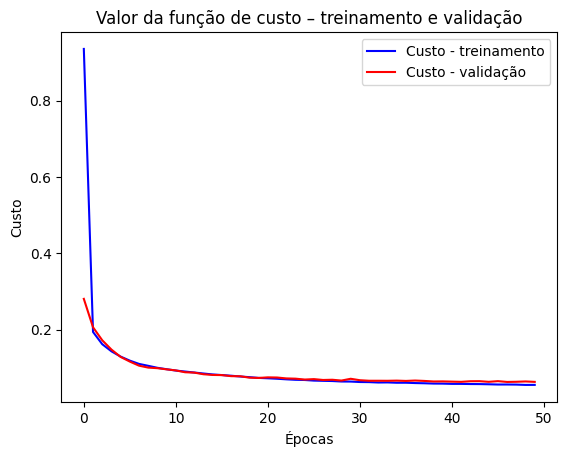

In [ ]:
""" PARA VOCÊ FAZER: GRáficos do processo de treinamento """

hist = history.history

# Gráfico dos valores de custo
plt.plot(hist['loss'], 'b', label='Custo - treinamento')
plt.plot(hist['val_loss'], 'r', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

### Exercício #11: Teste da rede siamesa

Para testar a rede siamesa vamos calcular as distâncias entre os vetores de varacterísticas das imagens dos pares de teste.

Considere que as imagens são iguais se a distância for menor do que $0.5M$ e diferentes se a distância for maior do que $0.5M$. Assim, identifique os pares de teste da seguinte forma:

1. Se a distância <= M/2, então, as imagens são similares e y_prev = 1
2. Se a distância > M/2, então, as imagens são diferentes e y_prev = 0

In [ ]:
""" PARA VOCÊ FAZER: Cálculo das classes dos pares de teste """

# Calcula saída prevista para os dados de teste
distances = siam.predict([par_test[:,0], par_test[:,1]])

# Inicilaiza saídas previstas de teste
y_prev_test = np.zeros(len(distances))

# Identifica as classes previstas
for i in range(len(distances)):
    if distances[i]<=MARGIN/2.0:
        y_prev_test[i] = 1

print('Distancias dos primeiros 10 exemplos:', distances[:10].T)
print('Classes reais dos primeiros 10 exemplos:', y_par_test[:10].T)
print('Classes previstas dos primeiros 10 exemplos:', y_prev_test[:10])

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Distancias dos primeiros 10 exemplos: [0.17532508 2.0246673  0.1776494  0.28166753 0.00218268 0.75939894
 0.00689625 1.0601404  0.00649687 0.9631814 ]
Classes reais dos primeiros 10 exemplos: [1 0 1 0 1 0 1 0 1 0]
Classes previstas dos primeiros 10 exemplos: [1. 0. 1. 1. 1. 0. 1. 0. 1. 0.]


**Saída prevista:**

    Distancias dos primeiros 10 exemplos: [0.06626939 0.79154617 0.01302315 1.6630442  0.05887018 1.3375069
    0.03222494 1.3675302  0.02616763 1.4972945 ]
    Classes reais dos primeiros 10 exemplos: [1 0 1 0 1 0 1 0 1 0]
    Classes previstas dos primeiros 10 exemplos: [1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
    
    
Execute a célula abaixo para calcular a exatidão da classificação dos pares de imagens de teste.

In [ ]:
# Calculo da extidão dos dados de treinamento e teste
exatidao = 1 - np.mean(np.abs(y_par_test-y_prev_test))

print('Exatidão:', exatidao)

Exatidão: 0.9186186186186186


**Saída prevista:**

    Exatidão: 0.9099599599599599

#### Execute a célula abaixo para visualizar o desempenho da sua rede siamensa nos pares de teste

Observe que cada bolinha azul é um erro de previsão da classe do par.

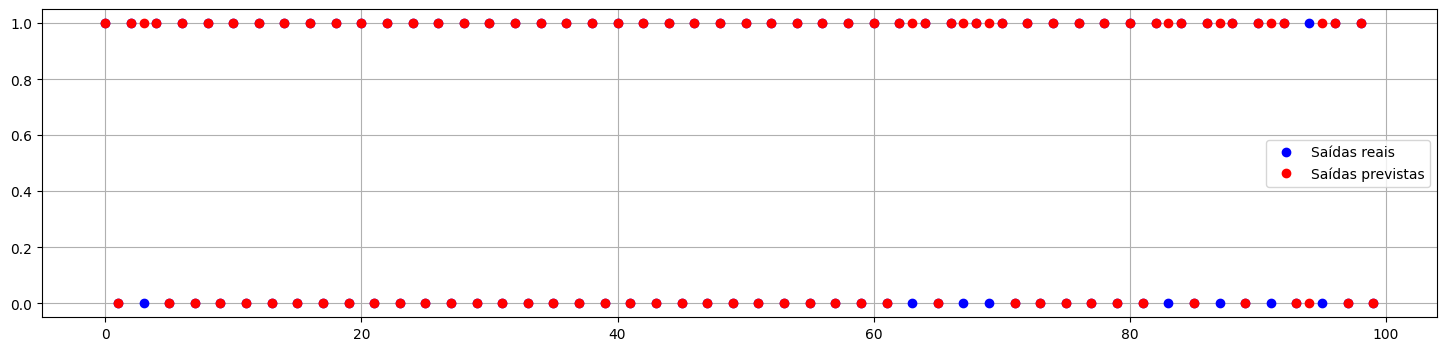

In [ ]:
# verificação dos 200 primeiros exemplos de teste
plt.figure(figsize=(18,4))
plt.plot(y_par_test[:100], 'bo', label='Saídas reais')
plt.plot(y_prev_test[:100], 'ro', label='Saídas previstas')
plt.legend()
plt.grid()
plt.show()

## 9. Conclusão

Uma exatidão de 92% nos dados de teste não é um resultado bom, mas também não é um resultado muito ruim.

Certamente esse resultado pode ser melhorando por meio de um ajuste dos hiperparâmetros do modelo, tais como:

1. Alteração do número de camadas, do número de neurônios e da função de ativação das camadas da rede de extração de características.

2. Alteração da margem da função de custo contrastante.

3. Alteração da taxa de dropout.

4. Utilização de uma arquitetura de rede mais complexa.